In [19]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys, random
import pandas as pd
import seaborn as sb
import sklearn
from sklearn import metrics
from IPython.display import display

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

In [2]:
# Global Variables

# Lists
fitsList=[]

starlist=[]
planetlist=[]
eblist=[]
beblist=[]

# List Holder
alllists = {}

# Keep track of current LC and it's TIC identifier
lastRandom={
    "number": 0,
    "id": 0
}

In [3]:
# Functions

# Function for Reading which LC datafiles we have into a list
def MakingAList(prnt=False):
    fl = []
    fitsroot = "SIM_DATA/"
    fits_directories = [x[0] for x in os.walk('./SIM_DATA/.', topdown=True)]

    for fitsroot, fits_dirs, fits_files in os.walk(fitsroot):
        for fits_file in fits_files:
            fullpath = os.path.join(fitsroot, fits_file)
            if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
                fl.append(fullpath)
    if prnt==True:
        print("Number of FITS files: {}".format(len(fl)))
    #print(len(fl))
    return fl

# Chooses a random number
def GetRandomLC(n = None):
    global lastRandom
    #print("1: {}".format(n))
    if isinstance(n, int):
        if 0 <= n < len(fitsList):
            n = n
        else:
            n = random.randint(0,len(fitsList))
    else:
        n = random.randint(0,len(fitsList))
    
    lastRandom["number"] = n
    lastRandom["id"] = str(fitsList[n].split("-")[2].lstrip("0"))
    return n

def DrawACurve(n=None):
    rndFile = GetRandomLC() if n == None else GetRandomLC(n)
    fitsFile = fitsList[rndFile]
    
    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
        # extension.
        #period = hdulist[1].header['TPERIOD']
        #duration = hdulist[1].header['TDUR']
        duration = (hdulist[1].header['LIVETIME'])
        #epoch = hdulist[1].header['TEPOCH']
        #depth = hdulist[1].header['TDEPTH']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        #times = hdulist[1].data['TIME']
        #phases = hdulist[1].data['PHASE']
        #fluxes_init = hdulist[1].data['LC_INIT']
        #model_fluxes_init = hdulist[1].data['MODEL_INIT']
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # Define the epoch of primary transit in TBJD.  Our timestamps are also already in TBJD.
    #t0 = 1327.520678

    # Start figure and axis.
    fig, ax = plt.subplots()

    # Plot the timeseries in black circles.
    ## Using the [1:-1] identifier to cut off the leading and trailing zeroes

    ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

    # Center the x-axis on where we expect a transit to be (time = T0), and set
    # the x-axis range within +/- 1 day of T0.
    ########ax.set_xlim(t0 - 1.0, t0 + 1.0)

    # Overplot a red vertical line that should be where the transit occurs.
    ########ax.axvline(x=t0, color="red")

    # Let's label the axes and define a title for the figure.
    fig.suptitle(CurrentLC())
    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    # Adjust the left margin so the y-axis label shows up.
    plt.subplots_adjust(left=0.15)
    #plt.figure(figsize=(2,8))
    plt.show()
    
def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])       # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

def LoadList(itemtype="all"):
    
    pl="tsop301_planet_data.txt"
    sl="tsop301_star_data.txt"
    ebl="tsop301_eb_data.txt"
    bebl="tsop301_backeb_data.txt"
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        global starlist
        starlist = LoadListGeneral(sl)
        print("Loading star list: {}".format(sl))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        global planetlist
        planetlist = LoadListGeneral(pl)
        print ("loading planet list: {}".format(pl))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        global eblist
        eblist = LoadListGeneral(ebl)
        print ("loading eb list: {}".format(ebl))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        global beblist
        beblist = LoadListGeneral(bebl)
        print ("loading beb list: {}".format(bebl))
        
    if foundflag:
        global alllists
        alllists = {"s": starlist, "p": planetlist, "eb": eblist, "beb": beblist}
        return
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")
        
def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

# Purely for convenience
def CurrentLC():
    return ("File № {} - {}".format(lastRandom["number"], lastRandom["id"]))

In [4]:
# RUN ALL INITIALISERS
def Initialise():
    global fitsList
    fitsList = MakingAList()
    LoadList()
Initialise()

Loading star list: tsop301_star_data.txt
loading planet list: tsop301_planet_data.txt
loading eb list: tsop301_eb_data.txt
loading beb list: tsop301_backeb_data.txt


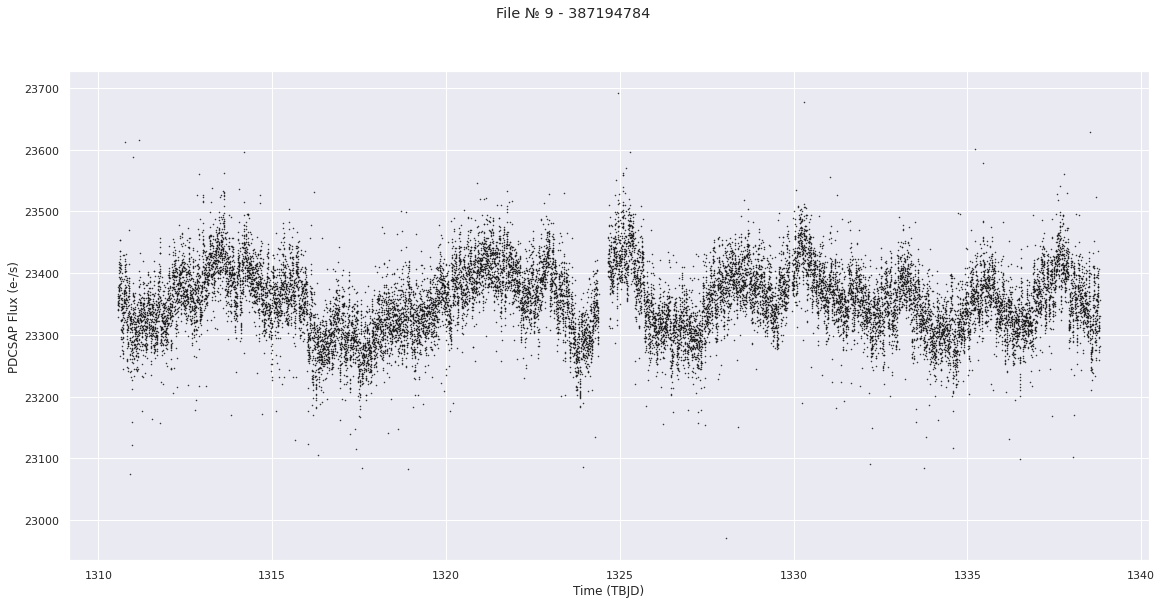

In [5]:
DrawACurve(9)

In [6]:
WhatIsMyLC(lastRandom["id"])

['Star', 'Planet']

In [7]:
# MAKE ME BIG DATAFRAME
def MakeData():
    
    # Initiatate Dataframe
    df = pd.DataFrame(columns=['a', 'b'])
    print(df)
    
    # Loop for each FITS file
    for e, li in enumerate(fitsList[:11].copy()):
        with open (li) as f:
        
            #Populate 'lastRandom' so store current number and id
            GetRandomLC(e)
            print(e,":",lastRandom["id"])#,":",li)
            
            # Get number and id
            rnum = lastRandom["number"]
            rid = lastRandom["id"]
            print(e,":",rid,":",IsThisAPlanet(rid))#,":",li)
            
            #initiate Data
            tmp = pd.DataFrame([e,rid,0,IsThisAPlanet(rid)])
            #print(tmp)
            #df.append(tmp)
    print(df)
MakeData()

Empty DataFrame
Columns: [a, b]
Index: []
0 : 277688819
0 : 277688819 : False
1 : 272466550
1 : 272466550 : False
2 : 101544343
2 : 101544343 : False
3 : 384387355
3 : 384387355 : False
4 : 31500881
4 : 31500881 : False
5 : 31621118
5 : 31621118 : False
6 : 382033361
6 : 382033361 : False
7 : 274059056
7 : 274059056 : False
8 : 31496515
8 : 31496515 : False
9 : 387194784
9 : 387194784 : True
10 : 293272754
10 : 293272754 : False
Empty DataFrame
Columns: [a, b]
Index: []


In [12]:
def MakeData():
    
    # Initiatate Dataframe
    df = pd.DataFrame(columns=['id', 'vals', 'isplanet'])
    
    # Loop for each FITS file
    for e, li in enumerate(fitsList[:11].copy()):
        with fits.open (li) as f:
            #Populate 'lastRandom' so store current number and id
            GetRandomLC(e)
            
            # Get number and id
            rnum = lastRandom["number"]
            rid = lastRandom["id"]
            
            #add Data
            df = df.append(pd.DataFrame([[rid,f[1].data['PDCSAP_FLUX'][1:-1],0]], columns=['id', 'vals', 'isplanet']), ignore_index=True)
    return(df)
MakeData()

,id,vals,isplanet
0,277688819,"[179952.0, 179979.34, 179668.58, 179833.98, 17...",0
1,272466550,"[21610.824, 21618.32, 21631.969, 21623.95, 216...",0
2,101544343,"[108729.734, 108670.54, 108613.875, 108629.734...",0
3,384387355,"[56039.613, 56027.977, 55994.34, 55974.965, 56...",0
4,31500881,"[18019.508, 17992.531, 17918.803, 18050.266, 1...",0
5,31621118,"[15713.963, 15768.366, 15669.804, 15690.217, 1...",0
6,382033361,"[33195.902, 33236.508, 33219.883, 33195.348, 3...",0
7,274059056,"[13581.554, 13575.529, 13549.103, 13547.579, 1...",0
8,31496515,"[33847.59, 34226.273, 36103.15, 33426.56, 3519...",0
9,387194784,"[23350.113, 23359.03, 23339.836, 23354.15, 233...",0


In [11]:
with fits.open (fitsList[0]) as f:
    print(f[1].data['PDCSAP_FLUX'][1:-1])
    print(len(f[1].data['PDCSAP_FLUX'][1:-1]))

[179952.   179979.34 179668.58 ... 180920.   181044.3  181062.84]
20338


In [29]:
#SKLearn refresher


from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

import statistics
from statistics import mean

# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=10, random_state=7)
# define the model
model = LogisticRegression()
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), np.std(n_scores)))

Accuracy: 0.824 (0.034)
